This runs DeepExplainer with the model trained on simualted genomic data from the DeepLIFT repo (https://github.com/kundajelab/deeplift/blob/master/examples/genomics/genomics_simulation.ipynb), using a dynamic reference (i.e. the reference varies depending on the input sequence; in this case, the reference is a collection of dinucleotide-shuffled versions of the input sequence)

In [1]:
#use tensorflow version 1.x for backwards compatibility
%tensorflow_version 1.x
#backward compat with the h5py version used to save the deeplift models
!pip uninstall -y h5py
!pip install h5py==2.10.0 

TensorFlow 1.x selected.
Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 2.9 MB 7.9 MB/s 


In [2]:
#install the branch of shap at AvantiShri/shap - this has
# custom features for computing hypothetical importance scores
%cd /content/
!git clone https://github.com/AvantiShri/shap.git
%cd shap
!pip install .
%cd /content/

/content
Cloning into 'shap'...
remote: Enumerating objects: 4893, done.
remote: Total 4893 (delta 0), reused 0 (delta 0), pack-reused 4893
Receiving objects: 100% (4893/4893), 112.56 MiB | 24.86 MiB/s, done.
Resolving deltas: 100% (3196/3196), done.
Checking out files: 100% (260/260), done.
/content/shap
Processing /content/shap
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for shap: filename=shap-0.29.3-cp37-cp37m-linux_x86_64.whl size=348873 sha256=f6aaf217e88a0ca65ef9ec5cd580941f7011e66c0b655197d0e7a1a12b888fba
  Stored in directory: /tmp/pip-ephem-wheel-cache-clyhxtli/wheels/ea/b3/a2/87ca0dc4b2280b7a7cae118affe88d65d9e307

Pull in the relevant data

In [3]:
! [[ ! -f sequences.simdata.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelJson.json ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelJson.json
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelWeights.h5 ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelWeights.h5
! [[ ! -f test.txt.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

--2021-10-20 09:19:53--  https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 629502 (615K) [application/octet-stream]
Saving to: ‘sequences.simdata.gz’

sequences.simdata.g 100%[===================>] 614.75K  --.-KB/s    in 0.03s   

2021-10-20 09:19:53 (19.6 MB/s) - ‘sequences.simdata.gz’ saved [629502/629502]

--2021-10-20 09:19:53--  https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelJson.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.c

Load the data

In [4]:
! pip install simdna

     |████████████████████████████████| 634 kB 9.2 MB/s 
  ERROR: Failed building wheel for simdna
  Running setup.py clean for simdna
Failed to build simdna
    Running setup.py install for simdna ... done
  DEPRECATION: simdna was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [5]:
import simdna.synthetic as synthetic
import gzip
data_filename = "sequences.simdata.gz"

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = [x.decode("utf-8").rstrip("\n") for x in test_ids_fh]
data = synthetic.read_simdata_file(data_filename, ids_to_load=ids_to_load)

In [6]:
import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in data.sequences])

Load the model

In [7]:
from keras.models import model_from_json

#load the keras model
keras_model_weights = "keras2_conv1d_record_5_model_PQzyq_modelWeights.h5"
keras_model_json = "keras2_conv1d_record_5_model_PQzyq_modelJson.json"

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Install the deeplift package for the dinucleotide shuffling and visualzation code

In [8]:
!pip install deeplift

  Created wheel for deeplift: filename=deeplift-0.6.13.0-py3-none-any.whl size=36449 sha256=f543b8377f2ec10dcce947a80f652125d519c5fcf016ddbd3cbca97c58944f1d
  Stored in directory: /root/.cache/pip/wheels/5f/0f/15/3cb70dbd2147a5c948da210c6a283d87ea19c8e8ecb941b21e
Successfully built deeplift


### Compute importance scores

Define the function that generates the reference, in this case by performing a dinucleotide shuffle of the given input sequence

In [9]:
from deeplift.dinuc_shuffle import dinuc_shuffle
from collections import Counter

#This generates 20 references per sequence
def dinuc_shuffle_several_times(list_containing_input_modes_for_an_example,
                                seed=1234):
  assert len(list_containing_input_modes_for_an_example)==1
  onehot_seq = list_containing_input_modes_for_an_example[0]
  rng = np.random.RandomState(seed)
  to_return = np.array([dinuc_shuffle(onehot_seq, rng=rng) for i in range(20)])
  return [to_return] #wrap in list for compatibility with multiple modes

Run DeepExplainer with the dynamic reference function


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Sequence idx 0
Actual contributions


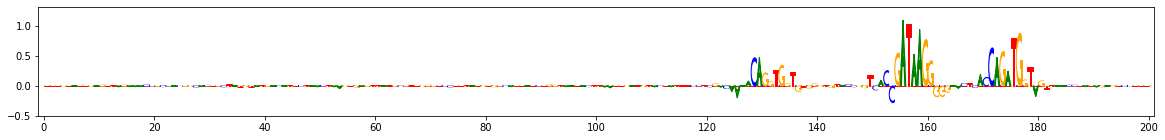

Hypothetical contributions


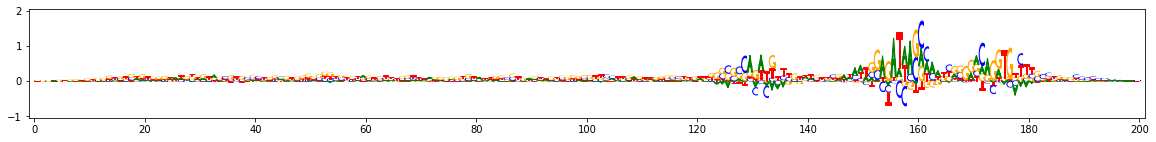

Sequence idx 1
Actual contributions


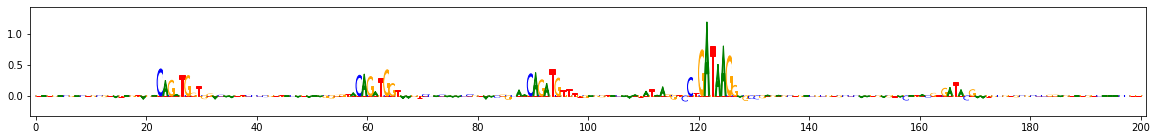

Hypothetical contributions


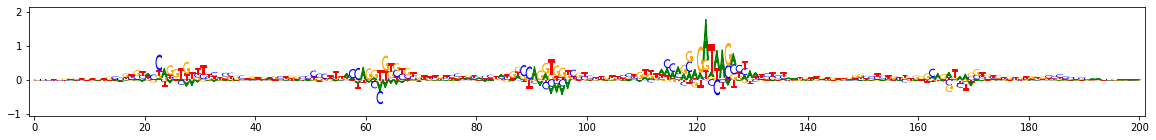

Sequence idx 2
Actual contributions


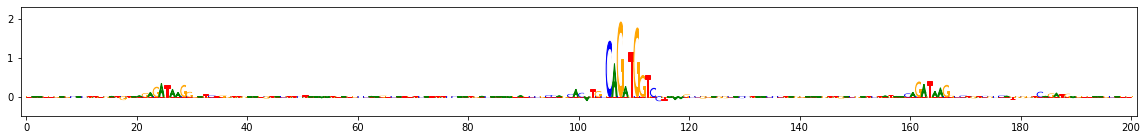

Hypothetical contributions


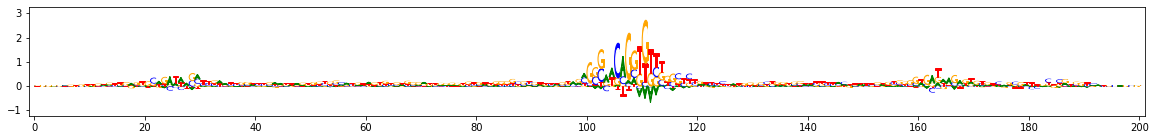

In [10]:
%matplotlib inline
from importlib import reload
from deeplift.visualization import viz_sequence
import shap
import shap.explainers.deep.deep_tf
reload(shap.explainers.deep.deep_tf)
reload(shap.explainers.deep)
reload(shap.explainers)
reload(shap)
import numpy as np
np.random.seed(1)
import random

#This combine_mult_and_diffref function can be used to generate hypothetical
# importance scores for one-hot encoded sequence.
#Hypothetical scores can be thought of as quick estimates of what the
# contribution *would have been* if a different base were present. Hypothetical
# scores are used as input to the importance score clustering algorithm
# TF-MoDISco (https://github.com/kundajelab/tfmodisco)
# Hypothetical importance scores are discussed more in this pull request:
#  https://github.com/kundajelab/deeplift/pull/36
def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    for l in range(len(mult)):
        projected_hypothetical_contribs = np.zeros_like(bg_data[l]).astype("float")
        assert len(orig_inp[l].shape)==2
        #At each position in the input sequence, we iterate over the one-hot encoding
        # possibilities (eg: for genomic sequence, this is ACGT i.e.
        # 1000, 0100, 0010 and 0001) and compute the hypothetical 
        # difference-from-reference in each case. We then multiply the hypothetical
        # differences-from-reference with the multipliers to get the hypothetical contributions.
        #For each of the one-hot encoding possibilities,
        # the hypothetical contributions are then summed across the ACGT axis to estimate
        # the total hypothetical contribution of each position. This per-position hypothetical
        # contribution is then assigned ("projected") onto whichever base was present in the
        # hypothetical sequence.
        #The reason this is a fast estimate of what the importance scores *would* look
        # like if different bases were present in the underlying sequence is that
        # the multipliers are computed once using the original sequence, and are not
        # computed again for each hypothetical sequence.
        for i in range(orig_inp[l].shape[-1]):
            hypothetical_input = np.zeros_like(orig_inp[l]).astype("float")
            hypothetical_input[:,i] = 1.0
            hypothetical_difference_from_reference = (hypothetical_input[None,:,:]-bg_data[l])
            hypothetical_contribs = hypothetical_difference_from_reference*mult[l]
            projected_hypothetical_contribs[:,:,i] = np.sum(hypothetical_contribs,axis=-1) 
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0))
    return to_return

seqs_to_explain = onehot_data[[0,3,9]] #these three are positive for task 0
#Instantiate the explainer. shuffle_several_times is the function that
# will be used to generate references for each sequence.
#combine_mult_and_diffref is the function that will be used to generate
# the hypothetical scores using the multipliers and difference-from-reference values.
dinuc_shuff_explainer = shap.DeepExplainer(
    #Importance is computed w.r.t. layers[-2] because that corresponds to the logit
    # of the sigmoid; we do this to avoid plateauing of importance scores due to
    # saturation of the sigmoid, as explained in the DeepLIFT paper
    #If you have a regression model, you should likely take layers[-1]
    (keras_model.input, keras_model.layers[-2].output[:,0]), dinuc_shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)
shap_explanations = dinuc_shuff_explainer.shap_values(seqs_to_explain)

for idx,(hypimpscores,orig_seq) in enumerate(zip(shap_explanations,seqs_to_explain)):
    print("Sequence idx",idx)
    print("Actual contributions")
    # (The actual importance scores can be computed using an element-wise product of
    #  the hypothetical importance scores and the actual importance scores)
    viz_sequence.plot_weights(hypimpscores*orig_seq, subticks_frequency=20)
    print("Hypothetical contributions")
    viz_sequence.plot_weights(hypimpscores, subticks_frequency=20)